In [1]:
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation

This notebook will help you with the numerical calculations for **Q6. Segway Tours** of HW13.

## Q6b

In [2]:
# define constants
m = 1
M = 10
g = 10
l = 1
k = 0.1
Delta = 1

# define A and \vec{b}
A = np.array([[0, 1, 0, 0],
              [0, -k/M, -(m*g)/M, 0],
              [0, 0, 0, 1],
              [0, k/(M*l), ((M+m)*g)/(M*l), 0]])
b = np.array([[0], [1/M], [0], [-1/(M*l)]])

In [3]:
# Eigendecomposition of A
eigs, V = np.linalg.eig(A)
V_inv = np.linalg.inv(V)

# Convert to discrete time parameters A_d and \vec{b}_d
Lambda_d = np.diag(np.exp(eigs * Delta))
A_d = V @ Lambda_d @ V_inv

num = np.exp(eigs * Delta) - 1
diag = np.ones_like(eigs) * Delta
for idx, ele in enumerate(eigs):
    if ele:
        diag[idx] = num[idx] / ele
M_d = np.diag(diag)
b_d = V @ M_d @ V_inv @ b

print(f'A_d={A_d}')
print(f'b_d={b_d}')

A_d=[[ 1.00000000e+00  9.94415377e-01 -1.16079593e+00 -2.85780440e-01]
 [ 0.00000000e+00  9.87198042e-01 -4.13800021e+00 -1.16079593e+00]
 [ 0.00000000e+00  1.16079593e-02  1.37973333e+01  4.14960817e+00]
 [ 0.00000000e+00  4.13800021e-02  4.56340819e+01  1.37973333e+01]]
b_d=[[ 0.05584623]
 [ 0.12801958]
 [-0.11607959]
 [-0.41380002]]


## Q6c: Controllability

In [4]:
Ab = A_d @ b_d
A2b = A_d @ Ab
A3b = A_d @ A2b
C = np.hstack([b_d, Ab, A2b, A3b])

rank_C = np.linalg.matrix_rank(C)
print(f'Rank of controllability matrix is {rank_C}')
print(f'C={C}')

Rank of controllability matrix is 4
C=[[ 5.58462342e-02  4.36151547e-01  8.51167588e+00  2.28658202e+02]
 [ 1.28019582e-01  1.08705545e+00  2.75699351e+01  7.57319406e+02]
 [-1.16079593e-01 -3.31721075e+00 -9.14068173e+01 -2.51868141e+03]
 [-4.13800021e-01 -1.10012251e+01 -3.03120454e+02 -8.35237928e+03]]


## Q6d and Q6e: Find input control sequence

In [5]:
state_final = np.array([[0], [0], [0], [0]])
state_initial = np.array([[-2], [3.1], [0.3], [-0.6]])  # 6d: linearization is valid
#state_initial = np.array([[-2], [3.1], [3.3], [-0.6]])  # 6e: linearization is not valid
A4 = A_d @ A_d @ A_d @ A_d
u_d = np.linalg.solve(C, state_final - A4 @ state_initial)
print(f'u_d={u_d}')

u_d=[[ -1.63640282]
 [ 48.6501389 ]
 [-97.74680957]
 [ 17.43307349]]


## Set up simulation (taken from 16A setup)

### Preamble

This function will take care of animating the segway. You do not have to understand the code in this cell for this HW.

In [6]:
# frames per second in simulation
fps = 20
# length of the segway arm/stick
stick_length = 20.

def animate_segway(t, states, controls, length):
    #Animates the segway
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # some config
    segway_width = 10.4
    segway_height = 10.2
    
    # x coordinate of the segway stick
    segwayStick_x = np.add(states[:, 0], length * np.sin(states[:, 2]))
    segwayStick_y = length * np.cos(states[:, 2])
    
    # set the limits
    xmin = min(np.around(states[:, 0].min() - segway_width / 2.0, 1), np.around(segwayStick_x.min(), 1))
    xmax = max(np.around(states[:, 0].max() + segway_width / 2.0, 1), np.around(segwayStick_x.max(), 1))
    
    # create the axes
    ax = plt.axes(xlim=(xmin-length, xmax+length), ylim=(-length * 1.2, length * 1.2), aspect='equal')
    
    # display the current time
    time_text = ax.text(0.05, 0.9, 'time', transform=ax.transAxes)
    
    # display the current control
    control_text = ax.text(0.05, 0.8, 'control', transform=ax.transAxes)
    
    # create rectangle for the segway
    rect = Rectangle([states[0, 0] - segway_width / 2.0, -segway_height / 2],
        segway_width, segway_height, fill=True, color='gold', ec='blue')
    ax.add_patch(rect)
    
    # blank line for the stick with o for the ends
    stick_line, = ax.plot([], [], lw=2, marker='o', markersize=6, color='blue')

    # vector for the control (force)
    force_vec = ax.quiver([],[],[],[],angles='xy',scale_units='xy',scale=1)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        control_text.set_text('')
        rect.set_xy((0.0, 0.0))
        stick_line.set_data([], [])
        return time_text, rect, stick_line, control_text

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        control_text.set_text('force = {:2.3f}'.format(controls[i]))
        rect.set_xy((states[i, 0] - segway_width / 2.0, -segway_height / 2))
        stick_line.set_data([states[i, 0], segwayStick_x[i]], [0, segwayStick_y[i]])
        return time_text, rect, stick_line, control_text

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=1000/fps, blit=False, repeat=False)
    return anim
    #plt.show()

### Simulation: Rerun this cell whenever you change any state or constants

You do not have to understand the code in this cell for this HW.

In [7]:
state0 = np.squeeze(state_initial)
controls = np.flip(np.squeeze(u_d))

# This will add an extra couple of seconds to the simulation after the input controls with no control
# the effect of this is just to show how the system will continue after the controller "stops controlling"
controls = np.append(controls,[0, 0])

# number of steps in the simulation
nr_steps = controls.shape[0]
nr_states = 4

# We now compute finer dynamics and control vectors for smoother visualization
Afine = fractional_matrix_power(A_d,(1/fps))
Asum = np.eye(nr_states)
for i in range(1, fps):
    Asum = Asum + np.linalg.matrix_power(Afine,i)
    
bfine = np.linalg.inv(Asum).dot(np.squeeze(b_d))

# We also expand the controls in the "intermediate steps" (only for visualization)
controls_final = np.outer(controls, np.ones(fps)).flatten()
controls_final = np.append(controls_final, [0])

# We compute all the states starting from x0 and using the controls
states = np.empty([fps*(nr_steps)+1, nr_states])
states[0,:] = state0;
for stepId in range(1,fps*(nr_steps)+1):
    states[stepId, :] = np.dot(Afine,states[stepId-1, :]) + controls_final[stepId-1] * bfine
    
# Now create the time vector for simulation
t = np.linspace(1/fps,nr_steps,fps*(nr_steps),endpoint=True)
t = np.append([0], t)

### Visualization

<IPython.core.display.Javascript object>


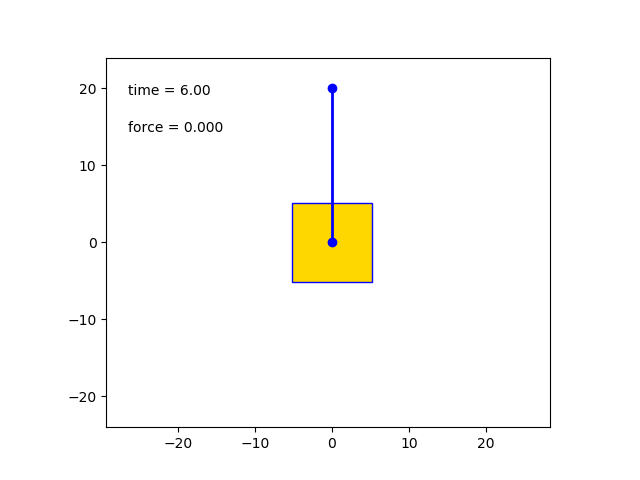

In [8]:
%matplotlib nbagg
anim = animate_segway(t, states, controls_final, stick_length)
anim